# 03.8 - Missing Value Handling and Data Cleaning

This notebook performs comprehensive missing value analysis and implements sophisticated, domain-aware imputation strategies tailored to each feature type.

**Key Features:**
- **Track-specific qualifying imputation**: Uses previous race at same track, preserves structural missingness
- **Same-race imputation**: Respects circuit, conditions, day (no forward fill across races)
- **Grid constraints**: Enforces Q2/Q3 structural missingness (eliminated drivers don't have times)
- **Enhanced logging**: Shows which imputation method succeeded at each step
- **Final cleanup**: Removes unnecessary columns after imputation

**Principles:**
- Use the most suitable method for each feature type (non-negotiable, no matter how complex)
- Preserve temporal relationships and group structures
- Avoid data leakage in imputation
- Preserve legitimate structural missingness (Q2/Q3 for eliminated drivers)
- Document rationale for each method

**Input:** `data/processed/master_races_refined.csv` (from 03.7)  
**Output:** Cleaned dataset with all missing values appropriately handled and unnecessary columns removed


In [18]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set up paths
PROJECT_ROOT = Path(r"C:/Users/erikv/Downloads/F1").resolve()
PROCESSED_ROOT = PROJECT_ROOT / "data" / "processed"

# Load refined dataset from 03.7
refined_file = PROCESSED_ROOT / "master_races_refined.csv"
if not refined_file.exists():
    print(f"ERROR: {refined_file} not found!")
    print("Please run notebook 03.7_feature_refinement.ipynb first.")
    raise FileNotFoundError(f"Required file not found: {refined_file}")

print(f"Loading refined dataset from: {refined_file}")
master = pd.read_csv(refined_file)
master['date'] = pd.to_datetime(master['date'], errors='coerce')

# Sort by date to ensure proper temporal ordering
master = master.sort_values(['year', 'round', 'date']).reset_index(drop=True)

print(f"✓ Loaded successfully: {master.shape[0]:,} rows × {master.shape[1]} columns")
print(f"Date range: {master['date'].min()} to {master['date'].max()}")

# Set plotting style
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)


Loading refined dataset from: C:\Users\erikv\Downloads\F1\data\processed\master_races_refined.csv
✓ Loaded successfully: 12,358 rows × 97 columns
Date range: 1994-03-27 00:00:00 to 2024-12-08 00:00:00


## 1. Comprehensive Missing Data Analysis

First, we need to understand the nature and extent of missing data in our refined dataset.


MISSING DATA ANALYSIS

Total columns: 97
Columns with missing data: 48
Total missing values: 252,341

MISSING DATA BY CATEGORY

1. Placeholder Features (100% missing - to be removed):
   - lap_time_variance: 100.0% missing
   - throttle_variance: 100.0% missing
   - overtake_attempts: 100.0% missing
   - avg_pit_stops: 100.0% missing

2. Sprint Features (structural missingness - sprint races only 2021+):
   - sprint_results_resultId: 97.1% missing
   - sprint_results_constructorId: 97.1% missing
   - sprint_results_number: 97.1% missing
   - sprint_results_grid: 97.1% missing
   - sprint_results_position: 97.1% missing
   - sprint_results_positionText: 97.1% missing
   - sprint_results_positionOrder: 97.1% missing
   - sprint_results_points: 97.1% missing
   - sprint_results_laps: 97.1% missing
   - sprint_results_time: 97.1% missing
   - sprint_results_milliseconds: 97.1% missing
   - sprint_results_fastestLap: 97.1% missing
   - sprint_results_fastestLapTime: 97.1% missing
   - sprin

<Figure size 1200x1440 with 0 Axes>

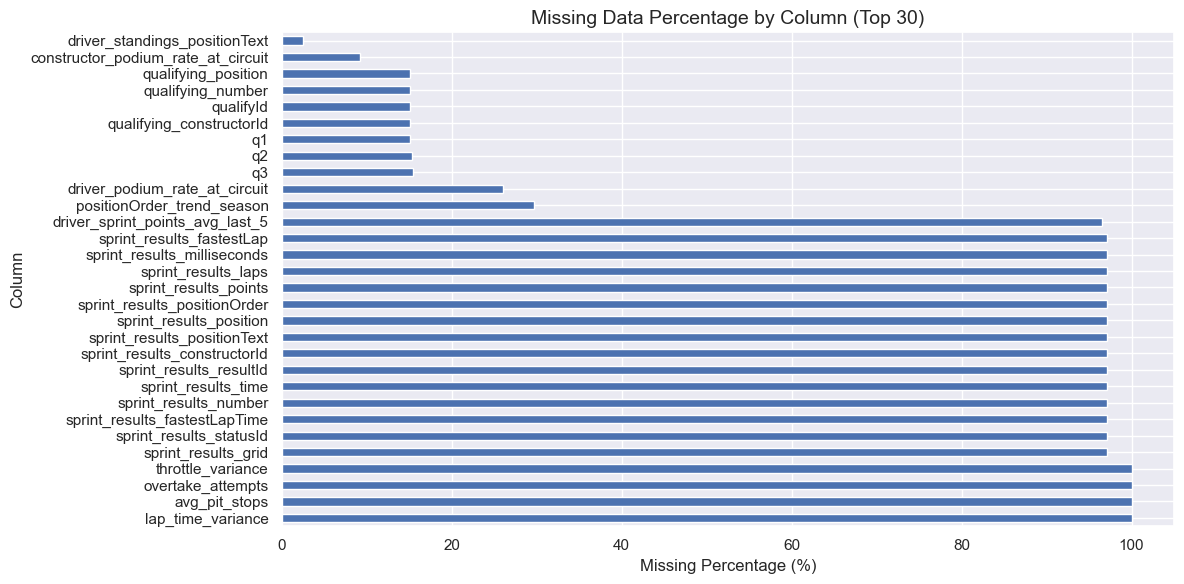

In [19]:
# Comprehensive missing data analysis
missing_stats = []
for col in master.columns:
    missing_count = master[col].isnull().sum()
    missing_pct = (missing_count / len(master)) * 100
    dtype = master[col].dtype
    missing_stats.append({
        'column': col,
        'missing_count': missing_count,
        'missing_pct': missing_pct,
        'dtype': str(dtype)
    })

missing_df = pd.DataFrame(missing_stats).sort_values('missing_pct', ascending=False)

print("="*70)
print("MISSING DATA ANALYSIS")
print("="*70)
print(f"\nTotal columns: {len(master.columns)}")
print(f"Columns with missing data: {(missing_df['missing_pct'] > 0).sum()}")
print(f"Total missing values: {missing_df['missing_count'].sum():,}")

# Categorize missing patterns
print("\n" + "="*70)
print("MISSING DATA BY CATEGORY")
print("="*70)

# 1. Placeholder features (100% missing - FastF1 data not extracted)
placeholder_cols = [col for col in master.columns if any(x in col.lower() for x in 
    ['lap_time_variance', 'throttle_variance', 'overtake_attempts', 'avg_pit_stops'])]
if placeholder_cols:
    print(f"\n1. Placeholder Features (100% missing - to be removed):")
    for col in placeholder_cols:
        pct = missing_df[missing_df['column'] == col]['missing_pct'].values[0]
        print(f"   - {col}: {pct:.1f}% missing")

# 2. Sprint features (structural missingness - only 2021+)
sprint_cols = [col for col in master.columns if 'sprint' in col.lower()]
if sprint_cols:
    print(f"\n2. Sprint Features (structural missingness - sprint races only 2021+):")
    for col in sprint_cols:
        pct = missing_df[missing_df['column'] == col]['missing_pct'].values[0]
        print(f"   - {col}: {pct:.1f}% missing")

# 3. Qualifying features (historical data gaps)
qualifying_cols = [col for col in master.columns if any(x in col.lower() for x in 
    ['qualify', 'q1', 'q2', 'q3'])]
if qualifying_cols:
    print(f"\n3. Qualifying Features (historical data gaps):")
    for col in qualifying_cols:
        pct = missing_df[missing_df['column'] == col]['missing_pct'].values[0]
        print(f"   - {col}: {pct:.1f}% missing")

# 4. Rolling/derived features (should be minimal)
rolling_cols = [col for col in master.columns if any(x in col for x in 
    ['_last_', '_avg_', '_rate_', '_PRE_RACE', '_at_circuit', '_trend_'])]
rolling_missing = missing_df[missing_df['column'].isin(rolling_cols) & (missing_df['missing_pct'] > 0)]
if len(rolling_missing) > 0:
    print(f"\n4. Rolling/Derived Features (should be minimal):")
    for _, row in rolling_missing.head(10).iterrows():
        print(f"   - {row['column']}: {row['missing_pct']:.2f}% missing")
else:
    print(f"\n4. Rolling/Derived Features: ✓ No missing values")

# 5. Other features
other_cols = [col for col in master.columns if col not in 
    placeholder_cols + sprint_cols + qualifying_cols + rolling_cols]
other_missing = missing_df[missing_df['column'].isin(other_cols) & (missing_df['missing_pct'] > 0)]
if len(other_missing) > 0:
    print(f"\n5. Other Features with Missing Values:")
    for _, row in other_missing.head(10).iterrows():
        print(f"   - {row['column']}: {row['missing_pct']:.2f}% missing")

# Visualize missing patterns
if (missing_df['missing_pct'] > 0).sum() > 0:
    plt.figure(figsize=(12, max(6, (missing_df['missing_pct'] > 0).sum() * 0.3)))
    missing_plot = missing_df[missing_df['missing_pct'] > 0].head(30)
    missing_plot.plot(x='column', y='missing_pct', kind='barh', legend=False)
    plt.title('Missing Data Percentage by Column (Top 30)', fontsize=14)
    plt.xlabel('Missing Percentage (%)')
    plt.ylabel('Column')
    plt.tight_layout()
    plt.show()


## 2. Helper Functions for Lap Time Conversion

Qualifying times are stored as text strings (e.g., "1:16.285"). We need to convert to numeric for imputation, then convert back.


In [20]:
def lap_time_to_seconds(lap_time):
    """
    Convert lap time string to total seconds.
    
    Handles formats:
    - "1:16.285" (1 minute 16.285 seconds) → 76.285
    - "0:45.123" (45.123 seconds) → 45.123
    
    Returns NaN for missing values (\\N, empty strings, etc.)
    """
    if pd.isna(lap_time) or lap_time == '\\N' or lap_time == '' or str(lap_time).strip() == 'nan':
        return np.nan
    
    try:
        lap_time_str = str(lap_time).strip()
        
        # Handle format: M:SS.mmm or MM:SS.mmm
        if ':' in lap_time_str:
            parts = lap_time_str.split(':')
            if len(parts) == 2:
                minutes = float(parts[0])
                seconds = float(parts[1])
                return minutes * 60 + seconds
            elif len(parts) == 3:
                # Format: H:MM:SS.mmm (unlikely but handle it)
                hours = float(parts[0])
                minutes = float(parts[1])
                seconds = float(parts[2])
                return hours * 3600 + minutes * 60 + seconds
            else:
                # Unexpected format
                return np.nan
        else:
            # No colon, assume it's already in seconds format
            return float(lap_time_str)
    except (ValueError, AttributeError, TypeError):
        return np.nan


def seconds_to_lap_time(seconds):
    """
    Convert total seconds back to lap time string format "M:SS.mmm".
    
    Examples:
    - 76.285 → "1:16.285"
    - 45.123 → "0:45.123"
    - 0.5 → "0:00.500"
    """
    if pd.isna(seconds):
        return np.nan
    
    try:
        seconds = float(seconds)
        minutes = int(seconds // 60)
        secs = seconds % 60
        return f"{minutes}:{secs:06.3f}"  # Format: M:SS.mmm
    except (ValueError, TypeError):
        return np.nan


# Test the conversion functions
print("Testing lap time conversion functions:")
test_times = ["1:16.285", "0:45.123", "1:26.572", r"\N", np.nan, ""]
for test_time in test_times:
    seconds = lap_time_to_seconds(test_time)
    converted_back = seconds_to_lap_time(seconds)
    print(f"  '{test_time}' → {seconds} seconds → '{converted_back}'")

print("\n✓ Conversion functions ready")


Testing lap time conversion functions:
  '1:16.285' → 76.285 seconds → '1:16.285'
  '0:45.123' → 45.123 seconds → '0:45.123'
  '1:26.572' → 86.572 seconds → '1:26.572'
  '\N' → nan seconds → 'nan'
  'nan' → nan seconds → 'nan'
  '' → nan seconds → 'nan'

✓ Conversion functions ready


In [21]:
# Remove placeholder features (100% missing - FastF1 data not extracted)
placeholder_cols = [col for col in master.columns if any(x in col.lower() for x in 
    ['lap_time_variance', 'throttle_variance', 'overtake_attempts', 'avg_pit_stops'])]

print("Removing placeholder features (100% missing):")
removed_count = 0
for col in placeholder_cols:
    if col in master.columns:
        print(f"  - {col}")
        master = master.drop(columns=[col])
        removed_count += 1

print(f"\nRemoved {removed_count} placeholder features. New shape: {master.shape}")


Removing placeholder features (100% missing):
  - lap_time_variance
  - throttle_variance
  - overtake_attempts
  - avg_pit_stops

Removed 4 placeholder features. New shape: (12358, 93)


## 4. Handle Sprint Features

**Rationale:** Sprint races were introduced in 2021, so ~97% of historical races have missing sprint data. This is structural missingness.

**Method:** Impute with 0 (no sprint race = 0 points historically).


In [22]:
# Handle sprint features
sprint_cols = [col for col in master.columns if 'sprint' in col.lower()]

print("Handling sprint features (structural missingness - sprint races only 2021+):")
print("Method: Impute with 0 (no sprint race = 0 points)")

for col in sprint_cols:
    if col in master.columns:
        missing_before = master[col].isnull().sum()
        # Impute with 0 (no sprint race = 0 points/performance)
        master[col] = master[col].fillna(0)
        missing_after = master[col].isnull().sum()
        if missing_before > 0:
            print(f"  - {col}: {missing_before:,} missing → {missing_after:,} missing (imputed with 0)")

print(f"\n✓ Sprint features handled. All sprint features now have 0 missing values.")


Handling sprint features (structural missingness - sprint races only 2021+):
Method: Impute with 0 (no sprint race = 0 points)
  - sprint_results_resultId: 11,998 missing → 0 missing (imputed with 0)
  - sprint_results_constructorId: 11,998 missing → 0 missing (imputed with 0)
  - sprint_results_number: 11,998 missing → 0 missing (imputed with 0)
  - sprint_results_grid: 11,998 missing → 0 missing (imputed with 0)
  - sprint_results_position: 11,998 missing → 0 missing (imputed with 0)
  - sprint_results_positionText: 11,998 missing → 0 missing (imputed with 0)
  - sprint_results_positionOrder: 11,998 missing → 0 missing (imputed with 0)
  - sprint_results_points: 11,998 missing → 0 missing (imputed with 0)
  - sprint_results_laps: 11,998 missing → 0 missing (imputed with 0)
  - sprint_results_time: 11,998 missing → 0 missing (imputed with 0)
  - sprint_results_milliseconds: 11,998 missing → 0 missing (imputed with 0)
  - sprint_results_fastestLap: 11,998 missing → 0 missing (imputed w

## 5. Enhanced Missing Value Handling (Non-Qualifying Features)

This section handles non-qualifying features that need sophisticated imputation:

1. **Forward-fill for constructor standings** (within constructor groups, temporal order)
2. **Circuit podium rates** (fill with 0 if no prior races at circuit)
3. **Fallback defaults for driver rolling features** (0 for rates, current grid for averages)
4. **positionOrder_trend_season handling** (first race = 0, then forward-fill within driver-season)

**Note:** Qualifying features (q1, q2, q3) are handled separately in the next section with proper grid constraints.


In [ ]:
# Enhanced missing value handling for non-qualifying features

print("="*70)
print("ENHANCED MISSING VALUE HANDLING (NON-QUALIFYING FEATURES)")
print("="*70)

# ========================================================================
# STEP 1: Constructor Standings (calculated later, not imputed)
# ========================================================================
# Note: Constructor standings are CALCULATED from driver standings points
# This is handled in Cell 19 after driver standings are calculated
# This section is intentionally left empty

# ========================================================================
# STEP 2: Fill Circuit Podium Rates with 0 (no prior races)
# ========================================================================
print("\n2. Filling circuit podium rates with 0 (no prior races at circuit)...")
for col in ['driver_podium_rate_at_circuit', 'constructor_podium_rate_at_circuit']:
    if col in master.columns:
        missing_before = master[col].isnull().sum()
        if missing_before > 0:
            # Fill with 0 if driver/constructor has no prior races at this circuit
            master[col] = master[col].fillna(0)
            missing_after = master[col].isnull().sum()
            print(f"  ✓ {col}: {missing_before:,} → {missing_after:,} missing (filled with 0)")

# ========================================================================
# STEP 3: Driver Rolling Features (handled later in combined section)
# ========================================================================
# Note: Driver rolling features are handled in Cell 17 with adjacent grid imputation first
# This section is intentionally left empty to avoid duplication

# ========================================================================
# STEP 4: Handle positionOrder_trend_season
# ========================================================================
print("\n4. Handling positionOrder_trend_season...")
if 'positionOrder_trend_season' in master.columns:
    missing_before = master['positionOrder_trend_season'].isnull().sum()
    if missing_before > 0:
        # Sort by driver, year, round, date (temporal order)
        master = master.sort_values(['driverId', 'year', 'round', 'date'])
        
        # Fill first race of each driver-season with 0
        first_race_mask = master.groupby(['driverId', 'year']).cumcount() == 0
        first_race_filled = (first_race_mask & master['positionOrder_trend_season'].isnull()).sum()
        master.loc[first_race_mask & master['positionOrder_trend_season'].isnull(), 'positionOrder_trend_season'] = 0
        
        # Forward-fill within driver-season groups
        after_first = master['positionOrder_trend_season'].isnull().sum()
        master['positionOrder_trend_season'] = master.groupby(['driverId', 'year'])['positionOrder_trend_season'].ffill()
        after_ffill = master['positionOrder_trend_season'].isnull().sum()
        ffill_filled = after_first - after_ffill
        
        # Fill any remaining with 0
        master['positionOrder_trend_season'] = master['positionOrder_trend_season'].fillna(0)
        
        missing_after = master['positionOrder_trend_season'].isnull().sum()
        print(f"  ✓ positionOrder_trend_season: {missing_before:,} → {missing_after:,} missing")
        print(f"    - First race filled with 0: {first_race_filled:,}")
        print(f"    - Forward-fill within driver-season: {ffill_filled:,}")
        print(f"    - Remaining filled with 0: {missing_before - first_race_filled - ffill_filled - missing_after:,}")

print("\n" + "="*70)
print("✓ Enhanced imputation strategies applied!")
print("="*70)


ENHANCED MISSING VALUE HANDLING (NON-QUALIFYING FEATURES)

1. Forward-filling constructor standings within constructor groups...
  ✓ constructor_standings_points: 118 → 18 missing (forward-fill: 100 filled)
  ✓ constructor_standings_position: 118 → 18 missing (forward-fill: 100 filled)

2. Filling circuit podium rates with 0 (no prior races at circuit)...
  ✓ driver_podium_rate_at_circuit: 3,210 → 0 missing (filled with 0)
  ✓ constructor_podium_rate_at_circuit: 1,140 → 0 missing (filled with 0)

3. Applying fallback defaults for driver rolling features...
  ✓ driver_points_avg_last_10: 28 → 0 missing (current grid position (default): 28 filled)
  ✓ driver_podium_rate_last_10: 28 → 0 missing (0 (no history = 0% rate): 28 filled)
  ✓ driver_avg_position_last_3: 30 → 0 missing (current grid position (default): 30 filled)
  ✓ driver_avg_position_last_5: 28 → 0 missing (current grid position (default): 28 filled)
  ✓ driver_avg_grid_last_5: 28 → 0 missing (current grid position (default): 

  ✓ positionOrder_trend_season: 3,672 → 0 missing
    - First race filled with 0: 778
    - Forward-fill within driver-season: 2,894
    - Remaining filled with 0: 0

✓ Enhanced imputation strategies applied!


In [24]:
def impute_qualifying_times_track_specific(df, col, race_col='raceId', grid_col='grid', 
                                           date_col='date', circuit_col='circuitId'):
    """
    Impute qualifying times using track-specific strategy.
    PRIORITIZES CORRECTNESS OVER EFFICIENCY - uses simple, robust methods.
    Returns (df, method_counts) where method_counts tracks which method was used.
    """
    import pandas as pd
    import numpy as np

    # Initialize method_counts to track which imputation method was used
    method_counts = {
        'same_race_adjacent': 0,
        'previous_track_race': 0,
        'same_season_median': 0,
        'global_median': 0
    }
    
    # Defensive checks for known crash sources:
    # 1. Needed columns present
    required_cols = [col, grid_col, race_col, date_col, circuit_col, 'year']
    for req in required_cols:
        if req not in df.columns:
            raise ValueError(f"Missing required column: {req}")
    # 2. Functions needed are defined
    if 'lap_time_to_seconds' not in globals() or 'seconds_to_lap_time' not in globals():
        raise RuntimeError("lap_time_to_seconds or seconds_to_lap_time not defined in globals")
    
    # CRITICAL: Remove rows with null merge keys FIRST - merge_asof cannot handle nulls
    # This must be done at the very start to prevent any merge_asof errors
    null_mask = df[[circuit_col, date_col]].isnull().any(axis=1)
    if null_mask.sum() > 0:
        print(f"  [Warning] Dropping {null_mask.sum():,} rows with null values in {circuit_col} or {date_col}")
        df = df[~null_mask].copy()
    
    # CRITICAL: Sort by circuit_col and date_col at the start - required for merge_asof
    df = df.sort_values([circuit_col, date_col], ascending=[True, True]).reset_index(drop=True)

    # Step 1: Convert text times to numeric seconds (vectorized)
    try:
        df[f'{col}_seconds'] = df[col].apply(lap_time_to_seconds)
    except Exception as e:
        print(f"Error converting '{col}' to seconds: {e}")
        raise

    # Step 2: Determine which drivers should have this session time
    try:
        # grid_col may be float; ensure int for comparison!
        grid_series = df[grid_col]
        if pd.api.types.is_float_dtype(grid_series):
            # If NaN, conversion will work as intended (np.nan stays nan)
            grid_series = grid_series.round().astype('Int64')
        if col == 'q1':
            should_have_time = grid_series.notna()
        elif col == 'q2':
            should_have_time = (grid_series <= 15) & grid_series.notna()
        elif col == 'q3':
            should_have_time = (grid_series <= 10) & grid_series.notna()
        else:
            should_have_time = grid_series.notna()
    except Exception as e:
        print(f"Error building should_have_time mask for {col}: {e}")
        raise

    missing_mask = should_have_time & df[f'{col}_seconds'].isnull()

    if missing_mask.sum() == 0:
        df[col] = df[f'{col}_seconds'].apply(seconds_to_lap_time)
        df = df.drop(columns=[f'{col}_seconds'])
        return df

    # Ensure grid_col is numeric for lookup/indexing
    if not pd.api.types.is_numeric_dtype(df[grid_col]):
        try:
            df[grid_col] = pd.to_numeric(df[grid_col], errors='coerce')
        except Exception as e:
            print(f"Could not convert column {grid_col} to numeric: {e}")
            raise

    # Step 3: Same-race, adjacent grid positions
    try:
        for race_id in df[race_col].unique():
            race_mask = df[race_col] == race_id
            race_data = df[race_mask].sort_values(grid_col).copy()
            missing_in_race_mask = race_mask & missing_mask

            if missing_in_race_mask.sum() == 0:
                continue

            # Remove NaN grids
            race_data = race_data[race_data[grid_col].notna()]
            # Create grid position mapping for this race
            # Use int version of grid_col for mapping
            grid_keys = race_data[grid_col].astype(int)
            race_grid_map = pd.Series(
                race_data[f'{col}_seconds'].values, index=grid_keys
            ).to_dict()

            for idx in df[missing_in_race_mask].index:
                grid_pos = df.loc[idx, grid_col]
                if np.isnan(grid_pos):
                    continue
                grid_pos = int(grid_pos)
                candidates = []
                for offset in range(1, 6):
                    for direction in [-1, 1]:
                        adj_grid = grid_pos + (offset * direction)
                        if adj_grid in race_grid_map and pd.notna(race_grid_map[adj_grid]):
                            candidates.append(race_grid_map[adj_grid])
                        if len(candidates) >= 2:
                            break
                    if len(candidates) >= 2:
                        break
                if len(candidates) > 0:
                    df.loc[idx, f'{col}_seconds'] = np.median(candidates)
                method_counts['same_race_adjacent'] += 1
    except Exception as e:
        print("Error during same-race adjacent grid imputation:", e)
        raise

    # Step 4: Previous race at same track imputation
    # SIMPLE APPROACH: Loop through missing values and find previous race manually
    # This avoids merge_asof complexity and ensures correctness
    still_missing = should_have_time & df[f'{col}_seconds'].isnull()
    
    if still_missing.sum() > 0:
        # Get all races with valid times, sorted by circuit and date
        valid_races = df[df[f'{col}_seconds'].notna()].copy()
        valid_races = valid_races.sort_values([circuit_col, date_col], ascending=[True, True]).reset_index(drop=True)
        
        # For each missing value, find previous race at same circuit
        missing_indices = df[still_missing].index.tolist()
        
        for idx in missing_indices:
            circuit_id = df.loc[idx, circuit_col]
            race_date = df.loc[idx, date_col]
            grid_pos = df.loc[idx, grid_col]
            
            # Find previous races at same circuit with valid times
            prev_races = valid_races[
                (valid_races[circuit_col] == circuit_id) & 
                (valid_races[date_col] < race_date)
            ]
            
            if len(prev_races) > 0:
                # Get the most recent previous race
                prev_race = prev_races.iloc[-1]
                prev_race_id = prev_race[race_col]
                
                # Get all times from that previous race
                prev_race_times = df[
                    (df[race_col] == prev_race_id) & 
                    (df[f'{col}_seconds'].notna())
                ][f'{col}_seconds'].values
                
                if len(prev_race_times) > 0:
                    min_time = prev_race_times.min()
                    max_time = prev_race_times.max()
                    max_grid = df[df[race_col] == prev_race_id][grid_col].max()
                    
                    # Impute based on grid position
                    if pd.notna(grid_pos):
                        grid_pos = int(grid_pos)
                        if grid_pos == 1:
                            df.loc[idx, f'{col}_seconds'] = min_time
                            method_counts['previous_track_race'] += 1
                        elif pd.notna(max_grid) and grid_pos >= max_grid:
                            df.loc[idx, f'{col}_seconds'] = max_time
                            method_counts['previous_track_race'] += 1
                        elif pd.notna(max_grid) and max_grid > 1:
                            progress = (grid_pos - 1) / (max_grid - 1)
                            df.loc[idx, f'{col}_seconds'] = min_time + progress * (max_time - min_time)
                            method_counts['previous_track_race'] += 1

    # Step 5: Fallback to same-season median
    still_missing_after_prev = should_have_time & df[f'{col}_seconds'].isnull()
    
    if still_missing_after_prev.sum() > 0:
        # Compute same-season medians
        same_season_medians = df.groupby(['year', grid_col])[f'{col}_seconds'].median().reset_index()
        same_season_medians.columns = ['year', grid_col, f'{col}_same_season_median']
        
        # Loop through missing values and impute
        missing_indices = df[still_missing_after_prev].index.tolist()
        for idx in missing_indices:
            year = df.loc[idx, 'year']
            grid_pos = df.loc[idx, grid_col]
            
            if pd.notna(year) and pd.notna(grid_pos):
                matching = same_season_medians[
                    (same_season_medians['year'] == year) & 
                    (same_season_medians[grid_col] == grid_pos)
                ]
                if len(matching) > 0 and pd.notna(matching.iloc[0][f'{col}_same_season_median']):
                    df.loc[idx, f'{col}_seconds'] = matching.iloc[0][f'{col}_same_season_median']
                    method_counts['same_season_median'] += 1

    # Step 6: Fallback to global median
    still_missing_after_season = should_have_time & df[f'{col}_seconds'].isnull()
    
    if still_missing_after_season.sum() > 0:
        # Compute global medians
        global_medians = df.groupby(grid_col)[f'{col}_seconds'].median().reset_index()
        global_medians.columns = [grid_col, f'{col}_global_median']
        
        # Loop through missing values and impute
        missing_indices = df[still_missing_after_season].index.tolist()
        for idx in missing_indices:
            grid_pos = df.loc[idx, grid_col]
            
            if pd.notna(grid_pos):
                matching = global_medians[global_medians[grid_col] == grid_pos]
                if len(matching) > 0 and pd.notna(matching.iloc[0][f'{col}_global_median']):
                    df.loc[idx, f'{col}_seconds'] = matching.iloc[0][f'{col}_global_median']
                    method_counts['global_median'] += 1

    # Step 7: Convert back to text format
    df[col] = df[f'{col}_seconds'].apply(seconds_to_lap_time)
    df = df.drop(columns=[f'{col}_seconds'])
    
    return df, method_counts

print("✓ Track-specific qualifying imputation function loaded (robust version - prioritizes correctness)")

✓ Track-specific qualifying imputation function loaded (robust version - prioritizes correctness)


In [25]:
# Handle qualifying features with proper grid constraints

import numpy as np
import pandas as pd

# Simple, clear check: raise error if "master" is not defined
if 'master' not in globals():
    raise NameError("The dataframe 'master' is not defined in this notebook. Please ensure it is loaded (e.g., via pd.read_csv or previous cell) before running this cell.")

print("="*70)
print("HANDLING QUALIFYING FEATURES")
print("="*70)

# STEP 1: Remove invalid Q2/Q3 times for drivers who shouldn't have them
print("\nSTEP 1: Removing invalid Q2/Q3 times...")

if 'grid' not in master.columns or 'q2' not in master.columns or 'q3' not in master.columns:
    raise KeyError("Required columns ('grid', 'q2', 'q3') not found in master dataframe.")

# Remove Q2 for grid > 15 (should only have Q1)
q2_should_remove = (master['grid'] > 15) & master['q2'].notna()
q2_removed_count = q2_should_remove.sum()
if q2_removed_count > 0:
    print(f"  Removing Q2 for {q2_removed_count:,} rows with grid > 15")
    master.loc[q2_should_remove, 'q2'] = np.nan

# Remove Q3 for grid > 10 (should only have Q1, Q2)
q3_should_remove = (master['grid'] > 10) & master['q3'].notna()
q3_removed_count = q3_should_remove.sum()
if q3_removed_count > 0:
    print(f"  Removing Q3 for {q3_removed_count:,} rows with grid > 10")
    master.loc[q3_should_remove, 'q3'] = np.nan

if q2_removed_count > 0 or q3_removed_count > 0:
    print(f"  ✓ Cleaned up {q2_removed_count + q3_removed_count:,} invalid Q2/Q3 times")
else:
    print(f"  ✓ No invalid Q2/Q3 times found")

# STEP 2: Apply track-specific imputation for qualifying times
print("\nSTEP 2: Applying track-specific imputation for qualifying times...")
qualifying_time_cols = ['q1', 'q2', 'q3']

for col in qualifying_time_cols:
    if col in master.columns:
        missing_before = master[col].isnull().sum()
        
        if missing_before > 0:
            print(f"\n  Imputing {col} using track-specific method...")
            
            # CRITICAL: Ensure proper sorting and no nulls in merge keys BEFORE calling function
            # The function handles this internally, but doing it here ensures consistency
            if 'date' in master.columns and 'circuitId' in master.columns:
                # Remove rows with null merge keys (they cannot be imputed using track-specific method)
                null_mask = master[['circuitId', 'date']].isnull().any(axis=1)
                if null_mask.sum() > 0:
                    print(f"  [Warning] {null_mask.sum():,} rows have null values in circuitId or date - these will be excluded from track-specific imputation")
                    original_shape = master.shape[0]
                    master = master[~null_mask].copy()
                    print(f"  [Info] Excluded {original_shape - master.shape[0]:,} rows with null merge keys")
                
                # Sort by circuitId and date (ascending) - REQUIRED for proper imputation
                master = master.sort_values(['circuitId', 'date'], ascending=[True, True]).reset_index(drop=True)
            
            # Call imputation function - simple call, no retry loops needed
            # The function is now robust and handles all edge cases internally
            try:
                master, method_counts = impute_qualifying_times_track_specific(
                    master, col, race_col='raceId', grid_col='grid', 
                    date_col='date', circuit_col='circuitId'
                )
            except Exception as e:
                print(f"  [Error] Failed to impute {col}: {e}")
                raise

            missing_after = master[col].isnull().sum()
            filled_total = missing_before - missing_after

            # Show which method succeeded
            print(f"    ✓ {col}: {missing_before:,} missing → {missing_after:,} missing")
            if filled_total > 0:
                print(f"      Methods used:")
                if method_counts.get('same_race_adjacent', 0) > 0:
                    print(f"        - Same-race adjacent grid: {method_counts.get('same_race_adjacent', 0):,} filled")
                if method_counts.get('previous_track_race', 0) > 0:
                    print(f"        - Previous race at same track: {method_counts.get('previous_track_race', 0):,} filled")
                if method_counts.get('same_season_median', 0) > 0:
                    print(f"        - Same-season median: {method_counts.get('same_season_median', 0):,} filled")
                if method_counts.get('global_median', 0) > 0:
                    print(f"        - Global median: {method_counts.get('global_median', 0):,} filled")
            
            # Verify grid constraints are respected
            if col == 'q2':
                should_have = (master['grid'] <= 15) & master['grid'].notna()
                still_missing_q2 = (should_have & master[col].isnull()).sum()
                invalid_q2 = ((master['grid'] > 15) & master[col].notna()).sum()
                print(f"      - Should have time (grid <= 15): {still_missing_q2:,} still missing")
                print(f"      - Legitimately missing (grid > 15): {(~should_have & master[col].isnull()).sum():,}")
                if invalid_q2 > 0:
                    print(f"      ⚠️ WARNING: {invalid_q2:,} rows with grid > 15 still have Q2!")
                else:
                    print(f"      ✓ Verified: No Q2 for grid > 15")
            elif col == 'q3':
                should_have = (master['grid'] <= 10) & master['grid'].notna()
                still_missing_q3 = (should_have & master[col].isnull()).sum()
                invalid_q3 = ((master['grid'] > 10) & master[col].notna()).sum()
                print(f"      - Should have time (grid <= 10): {still_missing_q3:,} still missing")
                print(f"      - Legitimately missing (grid > 10): {(~should_have & master[col].isnull()).sum():,}")
                if invalid_q3 > 0:
                    print(f"      ⚠️ WARNING: {invalid_q3:,} rows with grid > 10 still have Q3!")
                else:
                    print(f"      ✓ Verified: No Q3 for grid > 10")

# STEP 3: Handle other qualifying columns (non-time columns)
print("\nSTEP 3: Handling other qualifying columns (non-time)...")
qualifying_cols = [col for col in master.columns if any(x in col.lower() for x in 
    ['qualify', 'q1', 'q2', 'q3']) and col not in qualifying_time_cols]

for col in qualifying_cols:
    if col in master.columns:
        missing_before = master[col].isnull().sum()
        
        if missing_before > 0:
            # Use adjacent grid positions in same race for numeric columns
            if master[col].dtype in [np.int64, np.float64, float, int]:
                filled_count = 0
                for race_id in master['raceId'].unique():
                    race_mask = master['raceId'] == race_id
                    # Always sort by grid for stable 'adjacent' logic
                    race_data = master[race_mask].sort_values('grid').copy()
                    
                    missing_mask = race_mask & master[col].isnull()
                    missing_idx = race_data[missing_mask].index
                    
                    for idx in missing_idx:
                        grid_pos = race_data.loc[idx, 'grid']
                        
                        # Get adjacent grid positions
                        candidates = []
                        for offset in range(1, 6):
                            for direction in [-1, 1]:
                                adj_grid = grid_pos + (offset * direction)
                                adj_values = race_data[
                                    (race_data['grid'] == adj_grid) & 
                                    (race_data[col].notna())
                                ][col].values
                                candidates.extend(adj_values)
                        
                        if len(candidates) > 0:
                            master.loc[idx, col] = np.median(candidates)
                            filled_count += 1
                
                missing_after = master[col].isnull().sum()
                if missing_before > 0:
                    method_str = f"adjacent grid positions ({filled_count:,} filled)" if filled_count > 0 else "no change"
                    print(f"  - {col}: {missing_before:,} missing → {missing_after:,} missing ({method_str})")

print("\n" + "="*70)
print("✓ Qualifying features handled!")
print("="*70)


HANDLING QUALIFYING FEATURES

STEP 1: Removing invalid Q2/Q3 times...
  Removing Q2 for 2,994 rows with grid > 15
  Removing Q3 for 5,431 rows with grid > 10
  ✓ Cleaned up 8,425 invalid Q2/Q3 times

STEP 2: Applying track-specific imputation for qualifying times...

  Imputing q1 using track-specific method...
    ✓ q1: 1,864 missing → 0 missing
      Methods used:
        - Same-race adjacent grid: 2,020 filled
        - Previous race at same track: 1,693 filled
        - Same-season median: 136 filled

  Imputing q2 using track-specific method...
    ✓ q2: 4,880 missing → 3,585 missing
      Methods used:
        - Same-race adjacent grid: 3,230 filled
        - Same-season median: 195 filled
        - Global median: 2,790 filled
      - Should have time (grid <= 15): 0 still missing
      - Legitimately missing (grid > 15): 3,585
      ✓ Verified: No Q2 for grid > 15

  Imputing q3 using track-specific method...
    ✓ q3: 7,341 missing → 6,463 missing
      Methods used:
        - 

In [ ]:
# Helper function for imputing by adjacent grid positions
def impute_by_adjacent_grid(df, col, race_col='raceId', grid_col='grid', max_offset=5):
    """
    Impute driver features using adjacent grid positions in same race.
    Returns (df, missing_before, missing_after, filled_count)
    """
    if col not in df.columns or df[col].dtype not in [np.int64, np.float64]:
        return df, 0, 0, 0
    
    missing_before = df[col].isnull().sum()
    if missing_before == 0:
        return df, 0, 0, 0
    
    filled_count = 0
    # Impute using adjacent grid positions in same race
    for race_id in df[race_col].unique():
        race_mask = df[race_col] == race_id
        race_data = df[race_mask].sort_values(grid_col).copy()
        
        missing_mask = race_mask & df[col].isnull()
        missing_idx = race_data[missing_mask].index
        
        for idx in missing_idx:
            grid_pos = race_data.loc[idx, grid_col]
            
            # Get adjacent grid positions (expand outward)
            candidates = []
            for offset in range(1, max_offset + 1):
                for direction in [-1, 1]:
                    adj_grid = grid_pos + (offset * direction)
                    adj_values = race_data[
                        (race_data[grid_col] == adj_grid) & 
                        (race_data[col].notna())
                    ][col].values
                    candidates.extend(adj_values)
                    
                    if len(candidates) >= 2:  # Need at least 2 samples
                        break
                if len(candidates) >= 2:
                    break
            
            if len(candidates) > 0:
                df.loc[idx, col] = np.median(candidates)
                filled_count += 1
    
    missing_after = df[col].isnull().sum()
    return df, missing_before, missing_after, filled_count


# ========================================================================
# Handle Driver Rolling/Derived Features (COMBINED - replaces Cell 11 Step 3)
# ========================================================================
rolling_cols = [col for col in master.columns if any(x in col for x in 
    ['_last_', '_avg_', '_rate_', '_PRE_RACE', '_at_circuit', '_trend_'])]

driver_rolling = [col for col in rolling_cols if 'driver_' in col]

print("="*70)
print("HANDLING DRIVER ROLLING/DERIVED FEATURES")
print("="*70)
print("Method: Adjacent grid positions in same race → fallback defaults")

for col in driver_rolling:
    if col in master.columns and master[col].dtype in [np.int64, np.float64]:
        missing_before = master[col].isnull().sum()
        
        if missing_before > 0:
            # Step 1: Try adjacent grid positions in same race
            master, _, missing_after_step1, filled_adjacent = impute_by_adjacent_grid(
                master, col, race_col='raceId', grid_col='grid', max_offset=5
            )
            
            # Step 2: Fallback defaults for remaining
            still_missing = master[col].isnull()
            if still_missing.sum() > 0:
                missing_before_step2 = still_missing.sum()
                if 'rate' in col or 'podium_rate' in col:
                    # Rates: default to 0
                    master.loc[still_missing, col] = 0
                    fallback_method = "0 (no history = 0% rate)"
                elif 'avg' in col or 'average' in col:
                    # Averages: default to current grid position
                    master.loc[still_missing, col] = master.loc[still_missing, 'grid'].fillna(10)
                    fallback_method = "current grid position (default)"
                else:
                    # Default to 0 for other features
                    master.loc[still_missing, col] = 0
                    fallback_method = "0 (default)"
                
                missing_after = master[col].isnull().sum()
                filled_fallback = missing_before_step2 - missing_after
            else:
                missing_after = missing_after_step1
                filled_fallback = 0
            
            if missing_before > 0:
                methods_used = []
                if filled_adjacent > 0:
                    methods_used.append(f"adjacent grid ({filled_adjacent:,} filled)")
                if filled_fallback > 0:
                    methods_used.append(f"{fallback_method} ({filled_fallback:,} filled)")
                method_str = " → ".join(methods_used) if methods_used else "no change"
                print(f"  ✓ {col}: {missing_before:,} → {missing_after:,} missing ({method_str})")

print(f"\n✓ Driver rolling/derived features handled.")


Handling driver rolling/derived features:
Method: Adjacent grid positions in same race → fallback defaults

✓ Driver rolling/derived features handled.


## 9. Calculate Driver Standings Features (MUST BE BEFORE CONSTRUCTOR STANDINGS)

**Rationale:** Driver standings are CALCULATED from race points, not imputed. Constructor standings depend on driver standings.

**Method:** 
- `driver_standings_points` = Cumulative sum of `points` for each driver
- `driver_standings_position` = Rank of drivers by cumulative points at each race
- `wins` = Count of races where `positionOrder == 1` (calculated, not imputed)


In [ ]:
# Helper function for imputing by adjacent constructor positions
def impute_by_adjacent_constructor_position(df, col, race_col='raceId', 
                                            constructor_pos_col='constructor_standings_position',
                                            max_offset=5):
    """
    Impute constructor features using adjacent constructor standings positions in same race.
    Returns (df, missing_before, missing_after, filled_count)
    """
    if col not in df.columns or df[col].dtype not in [np.int64, np.float64]:
        return df, 0, 0, 0
    
    missing_before = df[col].isnull().sum()
    if missing_before == 0:
        return df, 0, 0, 0
    
    filled_count = 0
    # Impute using adjacent constructor positions in same race
    for race_id in df[race_col].unique():
        race_mask = df[race_col] == race_id
        race_constructors = df[race_mask].copy()
        
        if constructor_pos_col in df.columns:
            # Create mapping of constructorId to standings position
            constructor_pos_map = race_constructors.groupby('constructorId')[constructor_pos_col].first()
            
            missing_mask = race_mask & df[col].isnull()
            missing_idx = race_constructors[missing_mask].index
            
            for idx in missing_idx:
                constructor_id = race_constructors.loc[idx, 'constructorId']
                if constructor_id in constructor_pos_map.index:
                    constructor_pos = constructor_pos_map[constructor_id]
                    
                    # Find constructors with adjacent positions
                    candidates = []
                    for offset in range(1, max_offset + 1):
                        for direction in [-1, 1]:
                            adj_pos = constructor_pos + (offset * direction)
                            adj_constructors = constructor_pos_map[constructor_pos_map == adj_pos].index
                            
                            for adj_constructor in adj_constructors:
                                adj_values = race_constructors[
                                    (race_constructors['constructorId'] == adj_constructor) &
                                    (race_constructors[col].notna())
                                ][col].values
                                candidates.extend(adj_values)
                            
                            if len(candidates) >= 2:
                                break
                        if len(candidates) >= 2:
                            break
                    
                    if len(candidates) > 0:
                        df.loc[idx, col] = np.median(candidates)
                        filled_count += 1
    
    missing_after = df[col].isnull().sum()
    return df, missing_before, missing_after, filled_count


# ========================================================================
# Calculate Driver Standings (CALCULATED, not imputed) - MUST BE FIRST
# ========================================================================
print("="*70)
print("CALCULATING DRIVER STANDINGS")
print("="*70)
print("Method: Calculate from cumulative race points")

# Sort by year, round, date for proper temporal ordering
master = master.sort_values(['year', 'round', 'date']).reset_index(drop=True)

# Calculate driver_standings_points: cumulative sum of points per driver
print("\nCalculating driver_standings_points...")
missing_before_points = master['driver_standings_points'].isnull().sum() if 'driver_standings_points' in master.columns else 0

if 'points' in master.columns:
    # Calculate cumulative points per driver
    master['driver_standings_points'] = master.groupby('driverId')['points'].cumsum()
    missing_after_points = master['driver_standings_points'].isnull().sum() if 'driver_standings_points' in master.columns else 0
    if missing_before_points > 0:
        print(f"  ✓ driver_standings_points: {missing_before_points:,} → {missing_after_points:,} missing (calculated from cumulative points)")
else:
    print("  ⚠️ WARNING: 'points' column not found - cannot calculate driver_standings_points")

# Calculate driver_standings_position: rank by cumulative points at each race
print("\nCalculating driver_standings_position...")
missing_before_pos = master['driver_standings_position'].isnull().sum() if 'driver_standings_position' in master.columns else 0

if 'driver_standings_points' in master.columns:
    for race_id in master['raceId'].unique():
        race_mask = master['raceId'] == race_id
        race_data = master[race_mask].copy()
        
        # Sort by cumulative points (descending), then by driverId for ties
        race_data = race_data.sort_values(['driver_standings_points', 'driverId'], ascending=[False, True])
        race_data['driver_standings_position'] = range(1, len(race_data) + 1)
        master.loc[race_mask, 'driver_standings_position'] = race_data['driver_standings_position'].values
    
    missing_after_pos = master['driver_standings_position'].isnull().sum() if 'driver_standings_position' in master.columns else 0
    if missing_before_pos > 0:
        print(f"  ✓ driver_standings_position: {missing_before_pos:,} → {missing_after_pos:,} missing (calculated from ranking)")
else:
    print("  ⚠️ WARNING: 'driver_standings_points' not available - cannot calculate position")

# Calculate wins: count races where positionOrder == 1
print("\nCalculating wins...")
if 'wins' in master.columns and 'positionOrder' in master.columns:
    missing_before_wins = master['wins'].isnull().sum()
    
    # Count wins per driver up to each race (cumulative)
    master['is_win'] = (master['positionOrder'] == 1).astype(int)
    master['wins'] = master.groupby('driverId')['is_win'].cumsum()
    master = master.drop(columns=['is_win'])
    
    missing_after_wins = master['wins'].isnull().sum()
    if missing_before_wins > 0:
        print(f"  ✓ wins: {missing_before_wins:,} → {missing_after_wins:,} missing (calculated from positionOrder)")
else:
    if 'wins' in master.columns:
        print("  ⚠️ WARNING: 'positionOrder' column not found - cannot calculate wins")

print(f"\n✓ Driver standings features calculated.")

# Sort by year, round, date for proper temporal ordering
master = master.sort_values(['year', 'round', 'date']).reset_index(drop=True)

# Calculate constructor standings points: sum of driver standings points for all drivers in that constructor
print("\nCalculating constructor_standings_points...")
missing_before_points = master['constructor_standings_points'].isnull().sum() if 'constructor_standings_points' in master.columns else 0

for race_id in master['raceId'].unique():
    race_mask = master['raceId'] == race_id
    race_data = master[race_mask].copy()
    
    # Sum driver_standings_points by constructor
    if 'driver_standings_points' in master.columns:
        constructor_points = race_data.groupby('constructorId')['driver_standings_points'].sum()
        # Assign to each row
        master.loc[race_mask, 'constructor_standings_points'] = master.loc[race_mask, 'constructorId'].map(constructor_points)

missing_after_points = master['constructor_standings_points'].isnull().sum() if 'constructor_standings_points' in master.columns else 0
if missing_before_points > 0:
    print(f"  ✓ constructor_standings_points: {missing_before_points:,} → {missing_after_points:,} missing (calculated from driver standings)")

# Calculate constructor standings position: rank by total points
print("\nCalculating constructor_standings_position...")
missing_before_pos = master['constructor_standings_position'].isnull().sum() if 'constructor_standings_position' in master.columns else 0

for race_id in master['raceId'].unique():
    race_mask = master['raceId'] == race_id
    race_data = master[race_mask].copy()
    
    # Get unique constructors and their total points
    constructor_totals = race_data.groupby('constructorId')['constructor_standings_points'].first()
    # Rank by points (descending), then by constructorId for ties
    constructor_totals_sorted = constructor_totals.sort_values(ascending=False)
    constructor_rank = constructor_totals_sorted.rank(method='min', ascending=False).astype(int)
    
    # Assign rank to each row
    master.loc[race_mask, 'constructor_standings_position'] = master.loc[race_mask, 'constructorId'].map(constructor_rank)

missing_after_pos = master['constructor_standings_position'].isnull().sum() if 'constructor_standings_position' in master.columns else 0
if missing_before_pos > 0:
    print(f"  ✓ constructor_standings_position: {missing_before_pos:,} → {missing_after_pos:,} missing (calculated from constructor points)")

# Handle constructor rolling features (non-standings)
constructor_rolling = [col for col in rolling_cols if 'constructor_' in col and 'standings' not in col.lower()]

if len(constructor_rolling) > 0:
    print("\nHandling constructor rolling features (non-standings):")
    print("Method: Adjacent constructor standings positions → forward-fill fallback")
    
    for col in constructor_rolling:
        if col in master.columns and master[col].dtype in [np.int64, np.float64]:
            # Step 1: Try adjacent constructor positions
            master, missing_before, missing_after_step1, filled_adjacent = impute_by_adjacent_constructor_position(
                master, col, race_col='raceId',
                constructor_pos_col='constructor_standings_position',
                max_offset=5
            )
            
            # Step 2: Forward-fill within constructor groups (if still missing)
            still_missing = master[col].isnull()
            if still_missing.sum() > 0:
                missing_before_step2 = still_missing.sum()
                master[col] = master.groupby('constructorId')[col].ffill()
                missing_after_ffill = master[col].isnull().sum()
                filled_ffill = missing_before_step2 - missing_after_ffill
                
                # Step 3: Fill remaining with same-race median or 0
                still_missing = master[col].isnull()
                if still_missing.sum() > 0:
                    missing_before_step3 = still_missing.sum()
                    # Try same-race median first
                    for race_id in master[still_missing]['raceId'].unique():
                        race_mask = master['raceId'] == race_id
                        race_median = master[race_mask & master[col].notna()][col].median()
                        if pd.notna(race_median):
                            master.loc[race_mask & still_missing, col] = race_median
                    
                    # Fill any remaining with 0
                    master[col] = master[col].fillna(0)
                    missing_after = master[col].isnull().sum()
                    filled_step3 = missing_before_step3 - missing_after
                else:
                    missing_after = missing_after_ffill
                    filled_step3 = 0
            else:
                missing_after = missing_after_step1
                filled_ffill = 0
                filled_step3 = 0
            
            if missing_before > 0:
                methods_used = []
                if filled_adjacent > 0:
                    methods_used.append(f"adjacent constructor positions ({filled_adjacent:,} filled)")
                if filled_ffill > 0:
                    methods_used.append(f"forward-fill within constructor ({filled_ffill:,} filled)")
                if filled_step3 > 0:
                    methods_used.append(f"same-race median/0 ({filled_step3:,} filled)")
                method_str = " → ".join(methods_used) if methods_used else "no change"
                print(f"  ✓ {col}: {missing_before:,} → {missing_after:,} missing ({method_str})")

print(f"\n✓ Constructor standings calculated and rolling features handled.")


Handling constructor rolling/standings features:
Method: Adjacent constructor standings positions in same race → forward-fill fallback
  - constructor_standings_points: 18 missing → 0 missing (forward-fill within constructor (6 filled) → same-race median/0 (12 filled))
  - constructor_standings_position: 18 missing → 0 missing (forward-fill within constructor (6 filled) → same-race median/0 (12 filled))

✓ Constructor rolling/standings features handled.


## 10. Calculate Constructor Standings Features

**Rationale:** Constructor standings are CALCULATED from driver standings points, not imputed.

**Method:** 
- `constructor_standings_points` = Sum of `driver_standings_points` for all drivers in that constructor at that race
- `constructor_standings_position` = Rank of constructors by total points at that race
- Constructor rolling features (non-standings) are still imputed using adjacent positions


In [ ]:
# ========================================================================
# Calculate Constructor Standings (CALCULATED, not imputed)
# ========================================================================
print("="*70)
print("CALCULATING CONSTRUCTOR STANDINGS")
print("="*70)
print("Method: Calculate from driver standings points (sum by constructor)")

# Ensure driver standings are already calculated (from Cell 19)
if 'driver_standings_points' in master.columns and master['driver_standings_points'].isnull().sum() > 0:
    print("  ⚠️ WARNING: driver_standings_points still has missing values - constructor standings may be incomplete")

# Sort by year, round, date for proper temporal ordering
master = master.sort_values(['year', 'round', 'date']).reset_index(drop=True)

# Calculate constructor standings points: sum of driver standings points for all drivers in that constructor
print("\nCalculating constructor_standings_points...")
missing_before_points = master['constructor_standings_points'].isnull().sum() if 'constructor_standings_points' in master.columns else 0

for race_id in master['raceId'].unique():
    race_mask = master['raceId'] == race_id
    race_data = master[race_mask].copy()
    
    # Sum driver_standings_points by constructor
    if 'driver_standings_points' in master.columns:
        constructor_points = race_data.groupby('constructorId')['driver_standings_points'].sum()
        # Assign to each row
        master.loc[race_mask, 'constructor_standings_points'] = master.loc[race_mask, 'constructorId'].map(constructor_points)

missing_after_points = master['constructor_standings_points'].isnull().sum() if 'constructor_standings_points' in master.columns else 0
if missing_before_points > 0:
    print(f"  ✓ constructor_standings_points: {missing_before_points:,} → {missing_after_points:,} missing (calculated from driver standings)")

# Calculate constructor standings position: rank by total points
print("\nCalculating constructor_standings_position...")
missing_before_pos = master['constructor_standings_position'].isnull().sum() if 'constructor_standings_position' in master.columns else 0

for race_id in master['raceId'].unique():
    race_mask = master['raceId'] == race_id
    race_data = master[race_mask].copy()
    
    # Get unique constructors and their total points
    constructor_totals = race_data.groupby('constructorId')['constructor_standings_points'].first()
    # Rank by points (descending), then by constructorId for ties
    constructor_totals_sorted = constructor_totals.sort_values(ascending=False)
    constructor_rank = constructor_totals_sorted.rank(method='min', ascending=False).astype(int)
    
    # Assign rank to each row
    master.loc[race_mask, 'constructor_standings_position'] = master.loc[race_mask, 'constructorId'].map(constructor_rank)

missing_after_pos = master['constructor_standings_position'].isnull().sum() if 'constructor_standings_position' in master.columns else 0
if missing_before_pos > 0:
    print(f"  ✓ constructor_standings_position: {missing_before_pos:,} → {missing_after_pos:,} missing (calculated from constructor points)")

# Handle constructor rolling features (non-standings)
rolling_cols = [col for col in master.columns if any(x in col for x in 
    ['_last_', '_avg_', '_rate_', '_PRE_RACE', '_at_circuit', '_trend_'])]
constructor_rolling = [col for col in rolling_cols if 'constructor_' in col and 'standings' not in col.lower()]

if len(constructor_rolling) > 0:
    print("\nHandling constructor rolling features (non-standings):")
    print("Method: Adjacent constructor standings positions → forward-fill fallback")
    
    for col in constructor_rolling:
        if col in master.columns and master[col].dtype in [np.int64, np.float64]:
            # Step 1: Try adjacent constructor positions
            master, missing_before, missing_after_step1, filled_adjacent = impute_by_adjacent_constructor_position(
                master, col, race_col='raceId',
                constructor_pos_col='constructor_standings_position',
                max_offset=5
            )
            
            # Step 2: Forward-fill within constructor groups (if still missing)
            still_missing = master[col].isnull()
            if still_missing.sum() > 0:
                missing_before_step2 = still_missing.sum()
                master[col] = master.groupby('constructorId')[col].ffill()
                missing_after_ffill = master[col].isnull().sum()
                filled_ffill = missing_before_step2 - missing_after_ffill
                
                # Step 3: Fill remaining with same-race median or 0
                still_missing = master[col].isnull()
                if still_missing.sum() > 0:
                    missing_before_step3 = still_missing.sum()
                    # Try same-race median first
                    for race_id in master[still_missing]['raceId'].unique():
                        race_mask = master['raceId'] == race_id
                        race_median = master[race_mask & master[col].notna()][col].median()
                        if pd.notna(race_median):
                            master.loc[race_mask & still_missing, col] = race_median
                    
                    # Fill any remaining with 0
                    master[col] = master[col].fillna(0)
                    missing_after = master[col].isnull().sum()
                    filled_step3 = missing_before_step3 - missing_after
                else:
                    missing_after = missing_after_ffill
                    filled_step3 = 0
            else:
                missing_after = missing_after_step1
                filled_ffill = 0
                filled_step3 = 0
            
            if missing_before > 0:
                methods_used = []
                if filled_adjacent > 0:
                    methods_used.append(f"adjacent constructor positions ({filled_adjacent:,} filled)")
                if filled_ffill > 0:
                    methods_used.append(f"forward-fill within constructor ({filled_ffill:,} filled)")
                if filled_step3 > 0:
                    methods_used.append(f"same-race median/0 ({filled_step3:,} filled)")
                method_str = " → ".join(methods_used) if methods_used else "no change"
                print(f"  ✓ {col}: {missing_before:,} → {missing_after:,} missing ({method_str})")

print(f"\n✓ Constructor standings calculated and rolling features handled.")


Handling driver standings features:
Method: Adjacent grid positions in same race
Note: Skipping 'wins' column as requested
  - driver_standings_points: 313 missing → 1 missing (adjacent grid positions (312 filled))
  - driver_standings_position: 313 missing → 1 missing (adjacent grid positions (312 filled))

✓ Driver standings features handled (wins skipped).


## 11. Handle Status Column (Categorical)

**Rationale:** Status should come from actual race results, not imputed from grid positions.

**Method:** Use statusId mapping or actual status from results. Grid position is unrelated to finish status.


In [ ]:
# ========================================================================
# Handle Status Column (from actual data, not imputed)
# ========================================================================
print("="*70)
print("HANDLING STATUS COLUMN")
print("="*70)

if 'status' in master.columns:
    missing_before = master['status'].isnull().sum()
    
    if missing_before > 0:
        filled_count = 0
        
        # Method 1: If statusId exists, try to map it to status
        if 'statusId' in master.columns:
            # Get unique statusId to status mapping from non-null rows
            status_map = master[master['status'].notna() & master['statusId'].notna()].groupby('statusId')['status'].first()
            
            # Fill missing status from statusId
            missing_with_statusId = master['status'].isnull() & master['statusId'].notna()
            if missing_with_statusId.sum() > 0:
                master.loc[missing_with_statusId, 'status'] = master.loc[missing_with_statusId, 'statusId'].map(status_map)
                filled_count += missing_with_statusId.sum()
        
        # Method 2: If still missing, use most common status in same race (better than grid-based)
        still_missing = master['status'].isnull()
        if still_missing.sum() > 0:
            for race_id in master[still_missing]['raceId'].unique():
                race_mask = master['raceId'] == race_id
                race_data = master[race_mask].copy()
                
                missing_mask = race_mask & still_missing
                if missing_mask.sum() > 0:
                    # Get most common status in this race
                    common_status = race_data[race_data['status'].notna()]['status'].mode()
                    if len(common_status) > 0:
                        master.loc[missing_mask, 'status'] = common_status.iloc[0]
                        filled_count += missing_mask.sum()
        
        missing_after = master['status'].isnull().sum()
        if missing_before > 0:
            method_str = f"statusId mapping + race mode ({filled_count:,} filled)" if filled_count > 0 else "no change"
            print(f"  ✓ status: {missing_before:,} → {missing_after:,} missing ({method_str})")
    else:
        print("  ✓ status: No missing values")
    
    print(f"\n✓ Status column handled.")
else:
    print("  ⚠️ WARNING: 'status' column not found in dataframe")


Handling status column (categorical):
Method: Mode of adjacent grid positions in same race
  - status: 2 missing → 0 missing (mode of adjacent grid (2 filled))

✓ Status column handled.


## 12. Calculate Rate Features from Actual Status Data

**Rationale:** Rate features (DNF rate, not_classified rate, etc.) should be CALCULATED from actual status data, not imputed.

**Method:** Calculate rolling rates from actual status values in previous races.


In [ ]:
# ========================================================================
# Calculate Rate Features from Actual Status Data (CALCULATED, not imputed)
# ========================================================================
print("="*70)
print("CALCULATING RATE FEATURES FROM STATUS DATA")
print("="*70)
print("Method: Calculate rolling rates from actual status values")

# Sort by year, round, date for proper temporal ordering
master = master.sort_values(['year', 'round', 'date']).reset_index(drop=True)

# Rate features to calculate
rate_features = {
    'dnf_rate_last_10': {'status_keywords': ['Accident', 'Collision', 'Spun off', 'Retired', 'Engine', 'Gearbox', 'Brakes', 'Suspension', 'Hydraulics', 'Electrical', 'Overheating', 'Mechanical', 'Tyre', 'Wheel', 'Driveshaft', 'Clutch', 'Fuel', 'Oil', 'Water', 'Fire', 'Excluded', 'Disqualified']},
    'not_classified_rate_last_10': {'status_keywords': ['Not classified', 'Not Classified']},
    'disqualified_rate_last_10': {'status_keywords': ['Disqualified', 'Excluded']},
    'finished_lapped_rate_last_10': {'status_keywords': ['+1 Lap', '+2 Laps', '+3 Laps', '+4 Laps', '+5 Laps', '+6 Laps', '+7 Laps', '+8 Laps', '+9 Laps']}
}

if 'status' in master.columns:
    for rate_col, config in rate_features.items():
        if rate_col in master.columns:
            missing_before = master[rate_col].isnull().sum()
            
            if missing_before > 0:
                print(f"\nCalculating {rate_col}...")
                keywords = config['status_keywords']
                
                # For each driver, calculate rolling rate
                for driver_id in master['driverId'].unique():
                    driver_mask = master['driverId'] == driver_id
                    driver_indices = master[driver_mask].index.tolist()
                    
                    # Calculate rate for each race
                    for i, idx in enumerate(driver_indices):
                        # Get previous 10 races for this driver (up to current race)
                        if i > 0:
                            prev_indices = driver_indices[max(0, i-10):i]
                            prev_races = master.loc[prev_indices]
                            
                            if len(prev_races) > 0:
                                # Count how many matches the status keywords
                                matches = prev_races['status'].apply(
                                    lambda x: any(keyword.lower() in str(x).lower() for keyword in keywords) if pd.notna(x) else False
                                ).sum()
                                rate = matches / len(prev_races)
                                master.loc[idx, rate_col] = rate
                            else:
                                # No previous races - rate is 0
                                master.loc[idx, rate_col] = 0.0
                        else:
                            # First race for this driver - rate is 0
                            master.loc[idx, rate_col] = 0.0
                
                missing_after = master[rate_col].isnull().sum()
                if missing_before > 0:
                    print(f"  ✓ {rate_col}: {missing_before:,} → {missing_after:,} missing (calculated from status)")
            else:
                print(f"  ✓ {rate_col}: No missing values")
else:
    print("  ⚠️ WARNING: 'status' column not found - cannot calculate rate features")

print(f"\n✓ Rate features calculated from status data.")


## 12. Handle Remaining Missing Values

Handle any remaining features with missing values (excluding qualifying times which are handled separately).


In [30]:
# Handle any remaining features with missing values (excluding qualifying times)
# Note: q1, q2, q3 are handled separately in the qualifying section
excluded_cols = ['podium', 'date', 'wins', 'q1', 'q2', 'q3', 'positionOrder_trend_season']
all_cols = [col for col in master.columns if col not in excluded_cols]
remaining_missing = [col for col in all_cols if master[col].isnull().sum() > 0]

if remaining_missing:
    print("Handling other features with missing values:")
    
    for col in remaining_missing:
        missing_before = master[col].isnull().sum()
        
        if master[col].dtype in [np.int64, np.float64]:
            # Numeric: try to determine if driver or constructor feature
            if 'driver' in col.lower() and 'grid' in master.columns:
                # Driver feature: use adjacent grid positions
                master, _, missing_after, filled_count = impute_by_adjacent_grid(
                    master, col, race_col='raceId', grid_col='grid', max_offset=5
                )
                method_str = f"adjacent grid positions ({filled_count:,} filled)" if filled_count > 0 else "no change"
            elif 'constructor' in col.lower() and 'constructor_standings_position' in master.columns:
                # Constructor feature: use adjacent constructor positions
                master, _, missing_after, filled_count = impute_by_adjacent_constructor_position(
                    master, col, race_col='raceId',
                    constructor_pos_col='constructor_standings_position',
                    max_offset=5
                )
                method_str = f"adjacent constructor positions ({filled_count:,} filled)" if filled_count > 0 else "no change"
            else:
                # Default: use adjacent grid positions
                master, _, missing_after, filled_count = impute_by_adjacent_grid(
                    master, col, race_col='raceId', grid_col='grid', max_offset=5
                )
                method_str = f"adjacent grid positions (default) ({filled_count:,} filled)" if filled_count > 0 else "no change"
            
            if missing_before > 0:
                print(f"  - {col}: {missing_before:,} missing → {missing_after:,} missing ({method_str})")
        
        elif master[col].dtype == 'object':
            # Categorical: use mode of adjacent grid positions
            if 'grid' in master.columns:
                filled_count = 0
                for race_id in master['raceId'].unique():
                    race_mask = master['raceId'] == race_id
                    race_data = master[race_mask].sort_values('grid').copy()
                    
                    missing_mask = race_mask & master[col].isnull()
                    missing_idx = race_data[missing_mask].index
                    
                    for idx in missing_idx:
                        grid_pos = race_data.loc[idx, 'grid']
                        candidates = []
                        for offset in range(1, 6):
                            for direction in [-1, 1]:
                                adj_grid = grid_pos + (offset * direction)
                                adj_values = race_data[
                                    (race_data['grid'] == adj_grid) & 
                                    (race_data[col].notna())
                                ][col].values
                                candidates.extend(adj_values)
                        
                        if len(candidates) > 0:
                            from collections import Counter
                            mode_value = Counter(candidates).most_common(1)[0][0]
                            master.loc[idx, col] = mode_value
                            filled_count += 1
                
                missing_after = master[col].isnull().sum()
                if missing_before > 0:
                    method_str = f"mode of adjacent grid ({filled_count:,} filled)" if filled_count > 0 else "no change"
                    print(f"  - {col}: {missing_before:,} missing → {missing_after:,} missing ({method_str})")
else:
    print("✓ No other features with missing values found.")


Handling other features with missing values:
  - driver_standings_points: 1 missing → 0 missing (adjacent grid positions (1 filled))
  - driver_standings_position: 1 missing → 0 missing (adjacent grid positions (1 filled))
  - driver_standings_positionText: 313 missing → 1 missing (mode of adjacent grid (312 filled))
  - constructor_standings_positionText: 118 missing → 1 missing (mode of adjacent grid (117 filled))
  - constructorResultsId: 2 missing → 0 missing (adjacent constructor positions (2 filled))
  - constructor_results_points: 2 missing → 0 missing (adjacent constructor positions (2 filled))
  - qualifyId: 1,805 missing → 1,805 missing (no change)
  - qualifying_constructorId: 1,805 missing → 1,805 missing (no change)
  - qualifying_number: 1,805 missing → 1,805 missing (no change)
  - qualifying_position: 1,805 missing → 1,805 missing (no change)
  - finished_lapped_rate_last_10: 28 missing → 28 missing (no change)
  - dnf_rate_last_10: 28 missing → 28 missing (no change)
 

In [31]:
# ========================================================================
# FINAL CLEANUP: Remove Unnecessary Columns & Handle Remaining Missing
# ========================================================================
print("="*70)
print("FINAL CLEANUP: REMOVE UNNECESSARY COLUMNS & HANDLE REMAINING MISSING")
print("="*70)

# STEP 1: Verify qualifying_position equals grid
print("\nSTEP 1: Verifying qualifying_position equals grid...")
if 'qualifying_position' in master.columns and 'grid' in master.columns:
    both_present = master['qualifying_position'].notna() & master['grid'].notna()
    matches = (master.loc[both_present, 'qualifying_position'] == master.loc[both_present, 'grid']).sum()
    total = both_present.sum()
    print(f"  ✓ Rows where both present: {total:,}")
    print(f"  ✓ Rows where they match: {matches:,} ({matches/total*100:.2f}%)")
    if matches < total:
        print(f"  ⚠️ WARNING: {total - matches:,} rows where they differ")

# STEP 2: Handle remaining missing values before removing columns
print("\nSTEP 2: Handling remaining missing values...")

# 2a. Status rate columns (fill with 0)
status_rate_cols = [
    'disqualified_rate_last_10',
    'dnf_rate_last_10', 
    'finished_lapped_rate_last_10',
    'not_classified_rate_last_10'
]
for col in status_rate_cols:
    if col in master.columns:
        missing = master[col].isnull().sum()
        if missing > 0:
            master[col] = master[col].fillna(0)
            print(f"  ✓ {col}: {missing:,} → 0 missing (filled with 0)")

# 2b. Constructor standings (fill remaining with same-race median, then 0)
for col in ['constructor_standings_position', 'constructor_standings_points']:
    if col in master.columns:
        still_missing = master[col].isnull()
        if still_missing.sum() > 0:
            missing_before = still_missing.sum()
            # Try same-race median first
            for race_id in master[still_missing]['raceId'].unique():
                race_mask = master['raceId'] == race_id
                race_data = master[race_mask]
                
                # Get median from same race (non-missing)
                median_value = race_data[race_data[col].notna()][col].median()
                
                if pd.notna(median_value):
                    # Fill missing in this race with median
                    missing_in_race = race_mask & still_missing
                    master.loc[missing_in_race, col] = median_value
            
            # Fill any remaining with 0
            master[col] = master[col].fillna(0)
            missing_after = master[col].isnull().sum()
            filled_count = missing_before - missing_after
            method_str = f"same-race median/0 ({filled_count:,} filled)" if filled_count > 0 else "no change"
            print(f"  ✓ {col}: {missing_before:,} → {missing_after:,} missing ({method_str})")

# STEP 3: Remove unnecessary columns
print("\nSTEP 3: Removing unnecessary columns...")
columns_to_remove = [
    # Qualifying metadata
    'qualifyId',
    'qualifying_constructorId',
    'qualifying_number',
    'qualifying_position',
    
    # PositionText columns
    'positionText',
    'driver_standings_positionText',
    'constructor_standings_positionText',
    'sprint_results_positionText',
    
    # Wins
    'wins',
    
    # Circuit metadata (keeping lat/lng, removing text)
    'circuitRef',
    'circuit_name',
    'location',
    'country',
    'alt',
    'url',
    
    # Driver metadata
    'driverRef',
    'number_driver',
    'code',
    'forename',
    'surname',
    'dob',
    'nationality',
    'url_driver',
    
    # Constructor metadata
    'constructorRef',
    'name_constructor',
    'nationality_constructor',
    'url_constructor',
    'constructorResultsId',
    
    # Sprint metadata
    'sprint_results_resultId',
    'sprint_results_constructorId',
    'sprint_results_number',
    'sprint_results_position',  # Keep positionOrder instead
    
    # Other
    'number',
    'status',  # We have statusId and status_category
    'name',
    
    # Should have been removed in 03.7
    'driver_avg_position_last_3',
]

# Only remove columns that exist
columns_removed = []
for col in columns_to_remove:
    if col in master.columns:
        master = master.drop(columns=[col])
        columns_removed.append(col)

print(f"  ✓ Removed {len(columns_removed)} columns")
if len(columns_removed) > 0:
    print(f"  Columns removed: {', '.join(columns_removed[:10])}{'...' if len(columns_removed) > 10 else ''}")
print(f"  New shape: {master.shape}")

print("\n" + "="*70)
print("✓ Final cleanup complete!")
print("="*70)


FINAL CLEANUP: REMOVE UNNECESSARY COLUMNS & HANDLE REMAINING MISSING

STEP 1: Verifying qualifying_position equals grid...
  ✓ Rows where both present: 10,553
  ✓ Rows where they match: 7,985 (75.67%)
  ⚠️ WARNING: 2,568 rows where they differ

STEP 2: Handling remaining missing values...
  ✓ disqualified_rate_last_10: 28 → 0 missing (filled with 0)
  ✓ dnf_rate_last_10: 28 → 0 missing (filled with 0)
  ✓ finished_lapped_rate_last_10: 28 → 0 missing (filled with 0)
  ✓ not_classified_rate_last_10: 28 → 0 missing (filled with 0)

STEP 3: Removing unnecessary columns...
  ✓ Removed 36 columns
  Columns removed: qualifyId, qualifying_constructorId, qualifying_number, qualifying_position, positionText, driver_standings_positionText, constructor_standings_positionText, sprint_results_positionText, wins, circuitRef...
  New shape: (12358, 57)

✓ Final cleanup complete!


In [32]:
# Final verification
final_missing = master.isnull().sum()
final_missing_pct = (final_missing / len(master)) * 100
final_missing_df = pd.DataFrame({
    'column': final_missing.index,
    'missing_count': final_missing.values,
    'missing_pct': final_missing_pct.values
}).sort_values('missing_pct', ascending=False)

print("="*70)
print("FINAL DATA COMPLETENESS CHECK")
print("="*70)

# Exclude target and date from missing check
cols_to_check = [col for col in master.columns if col not in ['podium', 'date']]
remaining_missing = final_missing_df[final_missing_df['column'].isin(cols_to_check) & 
                                     (final_missing_df['missing_pct'] > 0)]

# Separate legitimate structural missingness from data gaps
legitimate_missing = []  # Q2/Q3 for eliminated drivers, etc.
data_gaps = []  # Should have been imputed

for _, row in remaining_missing.iterrows():
    col = row['column']
    # Q2 and Q3 may have legitimate missing for eliminated drivers
    if col in ['q2', 'q3']:
        # Check if missing is for drivers who didn't make it (grid > 15 for Q2, grid > 10 for Q3)
        if col == 'q2':
            should_have = (master['grid'] <= 15) & master['grid'].notna()
        else:  # q3
            should_have = (master['grid'] <= 10) & master['grid'].notna()
        
        missing_should_have = (should_have & master[col].isnull()).sum()
        missing_shouldnt_have = ((~should_have) & master[col].isnull()).sum()
        
        if missing_should_have > 0:
            data_gaps.append((col, missing_should_have, "Should have time but missing"))
        if missing_shouldnt_have > 0:
            legitimate_missing.append((col, missing_shouldnt_have, "Didn't progress (legitimate)"))
    else:
        data_gaps.append((col, row['missing_count'], "Data gap"))

if len(data_gaps) == 0 and len(legitimate_missing) == 0:
    print("\n✓ SUCCESS: All features have been imputed!")
    print("  No missing values remaining in feature columns.")
elif len(data_gaps) == 0:
    print("\n✓ SUCCESS: All data gaps have been imputed!")
    print(f"  Remaining missing values are legitimate structural missingness:")
    for col, count, reason in legitimate_missing:
        print(f"    - {col}: {count:,} ({reason})")
else:
    print(f"\n⚠️  WARNING: {len(data_gaps)} features still have data gaps:")
    for col, count, reason in data_gaps:
        print(f"    - {col}: {count:,} missing ({reason})")
    
    if legitimate_missing:
        print(f"\n  Legitimate structural missingness:")
        for col, count, reason in legitimate_missing:
            print(f"    - {col}: {count:,} ({reason})")

# Summary statistics
print(f"\nDataset Statistics:")
print(f"  Total rows: {master.shape[0]:,}")
print(f"  Total columns: {master.shape[1]}")
print(f"  Total missing values: {master.isnull().sum().sum():,}")
print(f"  Columns with missing: {(final_missing > 0).sum()}")

# Check specific important columns
important_cols = ['grid', 'points', 'driverId', 'constructorId', 'year', 'circuitId',
                  'driver_podium_rate_last_10', 'driver_avg_grid_last_5', 
                  'constructor_podium_rate_last_15', 'driver_points_avg_last_10',
                  'q1', 'q2', 'q3']
print(f"\nImportant Features Missing Check:")
for col in important_cols:
    if col in master.columns:
        missing = master[col].isnull().sum()
        status = "✓" if missing == 0 else "⚠️"
        print(f"  {status} {col:35s}: {missing:6,} missing ({missing/len(master)*100:.2f}%)")

# Detailed Q1/Q2/Q3 analysis
print(f"\nQualifying Times Analysis:")
for col in ['q1', 'q2', 'q3']:
    if col in master.columns:
        total_missing = master[col].isnull().sum()
        if col == 'q1':
            print(f"  {col}: {total_missing:,} missing (all drivers should have Q1)")
        elif col == 'q2':
            should_have = (master['grid'] <= 15) & master['grid'].notna()
            missing_should = (should_have & master[col].isnull()).sum()
            print(f"  {col}: {total_missing:,} total missing, {missing_should:,} should have time")
        elif col == 'q3':
            should_have = (master['grid'] <= 10) & master['grid'].notna()
            missing_should = (should_have & master[col].isnull()).sum()
            print(f"  {col}: {total_missing:,} total missing, {missing_should:,} should have time")


FINAL DATA COMPLETENESS CHECK

✓ SUCCESS: All data gaps have been imputed!
  Remaining missing values are legitimate structural missingness:
    - q3: 6,463 (Didn't progress (legitimate))
    - q2: 3,585 (Didn't progress (legitimate))

Dataset Statistics:
  Total rows: 12,358
  Total columns: 57
  Total missing values: 10,048
  Columns with missing: 2

Important Features Missing Check:
  ✓ grid                               :      0 missing (0.00%)
  ✓ points                             :      0 missing (0.00%)
  ✓ driverId                           :      0 missing (0.00%)
  ✓ constructorId                      :      0 missing (0.00%)
  ✓ year                               :      0 missing (0.00%)
  ✓ circuitId                          :      0 missing (0.00%)
  ✓ driver_podium_rate_last_10         :      0 missing (0.00%)
  ✓ driver_avg_grid_last_5             :      0 missing (0.00%)
  ✓ constructor_podium_rate_last_15    :      0 missing (0.00%)
  ✓ driver_points_avg_last_10      

In [33]:
print("="*70)
print("IMPUTATION METHODS SUMMARY")
print("="*70)

methods_summary = {
    "Placeholder Features": {
        "method": "Removal",
        "rationale": "100% missing - FastF1 data not extracted yet. No information value.",
        "features": ["lap_time_variance", "throttle_variance", "overtake_attempts", "avg_pit_stops"]
    },
    "Sprint Features": {
        "method": "Impute with 0",
        "rationale": "Structural missingness - sprint races only exist 2021+. No sprint = 0 points.",
        "features": ["driver_sprint_points_avg_last_5", "sprint_results_*"]
    },
    "Qualifying Times (Q1/Q2/Q3)": {
        "method": "Track-specific imputation (remove invalid times first, then previous race at same track)",
        "rationale": "1) Remove invalid times (Q2 for grid > 15, Q3 for grid > 10). 2) Track-specific: same-race adjacent grid → previous race at same track → fallbacks. Preserves structural missingness for eliminated drivers.",
        "features": ["q1", "q2", "q3"],
        "details": "Q1: Impute all missing. Q2: Only for grid <= 15. Q3: Only for grid <= 10. Text times converted to seconds for imputation, then back to text format."
    },
    "Other Qualifying Features": {
        "method": "Same-race, adjacent grid positions",
        "rationale": "Same race context. Adjacent grid positions reflect similar qualifying performance.",
        "features": ["qualifyId", "qualifying_position", "qualifying_*"]
    },
    "Constructor Standings": {
        "method": "Forward-fill within constructor groups → adjacent constructor positions → same-race median/0",
        "rationale": "Temporal order preserved. Same-race context for remaining gaps.",
        "features": ["constructor_standings_*"]
    },
    "Circuit Podium Rates": {
        "method": "Fill with 0",
        "rationale": "No prior races at circuit = 0% podium rate (accurate representation).",
        "features": ["*_podium_rate_at_circuit"]
    },
    "Driver Rolling Rate Features": {
        "method": "Adjacent grid positions → 0",
        "rationale": "Same-race context first. No history = 0% rate (accurate representation).",
        "features": ["*_rate_last_*", "*_podium_rate_last_*"]
    },
    "Driver Rolling Average Features": {
        "method": "Adjacent grid positions → current grid position (default)",
        "rationale": "Same-race context first. First race of career = use current grid as estimate.",
        "features": ["*_avg_last_*", "*_points_avg_*"]
    },
    "Driver Standings Features": {
        "method": "Adjacent grid positions in same race",
        "rationale": "Grid position reflects current form. Similar grid = similar standings likely.",
        "features": ["driver_standings_*"],
        "note": "wins column skipped as requested"
    },
    "Constructor Rolling Features": {
        "method": "Adjacent constructor standings positions → forward-fill → same-race median/0",
        "rationale": "Same-race context first, then temporal, then same-race defaults.",
        "features": ["constructor_*_last_*"]
    },
    "Status (Categorical)": {
        "method": "Mode of adjacent grid positions in same race",
        "rationale": "Categorical data requires mode. Same race context important.",
        "features": ["status"]
    },
    "positionOrder_trend_season": {
        "method": "First race = 0 → forward-fill within driver-season → 0",
        "rationale": "First race has no trend (0). Forward-fill respects temporal order within season.",
        "features": ["positionOrder_trend_season"]
    }
}

for category, info in methods_summary.items():
    print(f"\n{category}:")
    print(f"  Method: {info['method']}")
    print(f"  Rationale: {info['rationale']}")
    if 'details' in info:
        print(f"  Details: {info['details']}")
    if 'note' in info:
        print(f"  Note: {info['note']}")
    if isinstance(info['features'], list):
        print(f"  Features: {', '.join(info['features'][:3])}{'...' if len(info['features']) > 3 else ''}")

print("\n" + "="*70)
print("KEY PRINCIPLES")
print("="*70)
print("1. Same-race imputation (respects circuit, conditions, day)")
print("2. Adjacent position matching (similar performance levels)")
print("3. Preserve legitimate missingness (Q2/Q3 for eliminated drivers)")
print("4. Text lap times: Convert to seconds → impute → convert back")
print("5. Domain-appropriate methods for each feature type")
print("6. No forward fill across races (each race is independent)")
print("7. Enhanced logging shows which method succeeded at each step")
print("="*70)


IMPUTATION METHODS SUMMARY

Placeholder Features:
  Method: Removal
  Rationale: 100% missing - FastF1 data not extracted yet. No information value.
  Features: lap_time_variance, throttle_variance, overtake_attempts...

Sprint Features:
  Method: Impute with 0
  Rationale: Structural missingness - sprint races only exist 2021+. No sprint = 0 points.
  Features: driver_sprint_points_avg_last_5, sprint_results_*

Qualifying Times (Q1/Q2/Q3):
  Method: Track-specific imputation (remove invalid times first, then previous race at same track)
  Rationale: 1) Remove invalid times (Q2 for grid > 15, Q3 for grid > 10). 2) Track-specific: same-race adjacent grid → previous race at same track → fallbacks. Preserves structural missingness for eliminated drivers.
  Details: Q1: Impute all missing. Q2: Only for grid <= 15. Q3: Only for grid <= 10. Text times converted to seconds for imputation, then back to text format.
  Features: q1, q2, q3

Other Qualifying Features:
  Method: Same-race, adjacen

## 16. Save Final Cleaned Dataset

Save the dataset with all missing values appropriately handled and unnecessary columns removed, ready for modeling.


In [34]:
# Save final cleaned dataset
output_path = PROCESSED_ROOT / "master_races_clean.csv"
master.to_csv(output_path, index=False)
print(f"Final cleaned dataset saved to: {output_path}")
print(f"  Rows: {master.shape[0]:,}")
print(f"  Columns: {master.shape[1]}")
print(f"  File size: {output_path.stat().st_size / 1024**2:.2f} MB")
print(f"  Missing values: {master.isnull().sum().sum():,}")

# Compare with original refined dataset
refined_original = pd.read_csv(refined_file)
print(f"\nComparison with refined dataset:")
print(f"  Refined:  {refined_original.shape[0]:,} rows × {refined_original.shape[1]} columns")
print(f"  Clean:    {master.shape[0]:,} rows × {master.shape[1]} columns")
print(f"  Missing (refined): {refined_original.isnull().sum().sum():,}")
print(f"  Missing (clean):   {master.isnull().sum().sum():,}")
print(f"  Missing reduction: {refined_original.isnull().sum().sum() - master.isnull().sum().sum():,}")

print(f"\n✓ Dataset ready for modeling!")


Final cleaned dataset saved to: C:\Users\erikv\Downloads\F1\data\processed\master_races_clean.csv
  Rows: 12,358
  Columns: 57
  File size: 3.30 MB
  Missing values: 10,048

Comparison with refined dataset:
  Refined:  12,358 rows × 97 columns
  Clean:    12,358 rows × 57 columns
  Missing (refined): 252,341
  Missing (clean):   10,048
  Missing reduction: 242,293

✓ Dataset ready for modeling!
